<a href="https://colab.research.google.com/github/Abhijeet141022/Quantum-Machine-Learning/blob/main/QSVM_MPQP_Qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mpqp

In [ ]:
from mpqp.execution import *
from mpqp import QCircuit

In [ ]:
from sympy import symbols
import numpy as np

In [ ]:
theta, k = symbols("Θ k")

In [ ]:
from mpqp.gates import X, CNOT, T, CZ, H, Ry, CRk, Rx, Rk, S, Y, Z, Rz
from mpqp.measures import BasisMeasure, ExpectationMeasure, Observable
from mpqp.noise import Depolarizing
from mpqp import Barrier

In [ ]:
#from mpqp.execution import run, ATOSDevice
#circuit = QCircuit([X(0), CNOT(0, 1), CZ(1, 2), BasisMeasure([0, 1, 2], shots=100)])
#print(circuit)
#print(run(circuit, ATOSDevice.MYQLM_PYLINALG))

     ┌───┐        ┌─┐      
q_0: ┤ X ├──■─────┤M├──────
     └───┘┌─┴─┐   └╥┘┌─┐   
q_1: ─────┤ X ├─■──╫─┤M├───
          └───┘ │  ║ └╥┘┌─┐
q_2: ───────────■──╫──╫─┤M├
                   ║  ║ └╥┘
c: 3/══════════════╩══╩══╩═
                   0  1  2 
Result: ATOSDevice, MYQLM_PYLINALG
  Counts: [0, 0, 0, 0, 0, 0, 100, 0]
  Probabilities: [0, 0, 0, 0, 0, 0, 1, 0]
  Samples:
    State: 110, Index: 6, Count: 100, Probability: 1
  Error: 0.0


In [ ]:
!pip install -q scikit-learn matplotlib

import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Generating a non-linearly separable dataset (Circles)
X, y = make_circles(n_samples=50, factor=0.5, noise=0.1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
import qiskit as qk
# Creating Qubits
q = qk.QuantumRegister(2)
# Creating Classical Bits
c = qk.ClassicalRegister(2)

In [ ]:
circuit = qk.QuantumCircuit(q, c)
print(circuit)

      
q2_0: 
      
q2_1: 
      
c1: 2/
      


In [ ]:
# Initializing empty circuit
circuit = qk.QuantumCircuit(q, c)
# Hadamard Gate on the first Qubit
circuit.h(q[0])
# CNOT Gate on the first and second Qubits
circuit.cx(q[0], q[1])
# Measuring the Qubits
circuit.measure(q, c)
print (circuit)

      ┌───┐     ┌─┐   
q2_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q2_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c1: 2/═══════════╩══╩═
                 0  1 


In [ ]:
from qiskit.circuit.library import PauliFeatureMap

In [ ]:
feature_map = PauliFeatureMap(feature_dimension=2)

In [ ]:
x = np.array([0.6, 0.3])
print(feature_map.assign_parameters(x))

     ┌───────────────────────────┐
q_0: ┤0                          ├
     │  PauliFeatureMap(0.6,0.3) │
q_1: ┤1                          ├
     └───────────────────────────┘


In [ ]:
from sklearn.svm import SVC

def get_execution_params(data1, data2=None):
    """
    Generate execution parameters based on the mode (train or validate).

    Parameters:
    - data1: First dataset (used for both training and validation).
    - data2: Second dataset (only required for validation).

    Returns:
    - A list of dictionaries with execution parameters.
    """
    if data2 is None:
        # Training mode (symmetric pairs of data1)
        return [
            {"data1": data1[k], "data2": data1[j]}
            for k in range(len(data1))
            for j in range(k, len(data1))  # Avoid symmetric pairs
        ]
    else:
        # Prediction mode
        return [
            {"data1": data1[k], "data2": data2[j]}
            for k in range(len(data1))
            for j in range(len(data2))
        ]


def construct_kernel_matrix(matrix_size, res_batch, train=False):
    """
    Construct a kernel matrix from `res_batch`, depending on whether it's for training or predicting.

    Parameters:
    - matrix_size: Tuple of (number of rows, number of columns) for the matrix.
    - res_batch: Precomputed batch results.
    - train: Boolean flag. If True, assumes training (symmetric matrix).

    Returns:
    - A kernel matrix as a NumPy array.
    """
    rows, cols = matrix_size
    kernel_matrix = np.zeros((rows, cols))

    num_shots = res_batch[0].num_shots
    num_output_qubits = len(next(iter(res_batch[0].counts)))

    count = 0
    if train:  # and rows == cols:
        # Symmetric matrix (training)
        for k in range(rows):
            for j in range(k, cols):
                value = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                kernel_matrix[k, j] = value
                kernel_matrix[j, k] = value  # Use symmetry
                count += 1
    else:
        # Non-symmetric matrix (validation)
        for k in range(rows):
            for j in range(cols):
                kernel_matrix[k, j] = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                count += 1

    return kernel_matrix


def train_svm(es, train_data, train_labels):
    """
    Trains an SVM model using a custom precomputed kernel from the training data.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - train_data: List of data points for training.
    - train_labels: List of binary labels corresponding to the training data.

    Returns:
    - svm_model: A trained SVM model using the precomputed kernel.
    """
    train_size = len(train_data)
    train_execution_params = get_execution_params(train_data)
    res_train_batch = es.batch_sample(train_execution_params)  # execute batch
    # generating kernel matrix for train
    kernel_train = construct_kernel_matrix(
        matrix_size=(train_size, train_size), res_batch=res_train_batch, train=True
    )
    svm_model = SVC(kernel="precomputed")
    svm_model.fit(
        kernel_train, train_labels
    )  # the fit gets the precomputed matrix of training, and the training labels

    return svm_model


def predict_svm(es, data, train_data, svm_model):
    """
    Predicts labels for new data using a precomputed kernel with a trained SVM model.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - data (list): List of new data points to predict.
    - train_data (list): Original training data used to train the SVM.
    - svm_model: A trained SVM model returned by `train_svm`.

    Returns:
    - y_predict (list): Predicted labels for the input data.
    """
    predict_size = len(data)
    train_size = len(train_data)
    predict_execution_params = get_execution_params(data, train_data)
    res_predict_batch = es.batch_sample(predict_execution_params)  # execute batch
    kernel_predict = construct_kernel_matrix(
        matrix_size=(predict_size, train_size), res_batch=res_predict_batch, train=False
    )
    y_predict = svm_model.predict(
        kernel_predict
    )  # the predict gets the precomputed test matrix

    return y_predict

In [ ]:
pip install qiskit qiskit-machine-learning

In [ ]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel

QSVM Test Accuracy: 100.00%


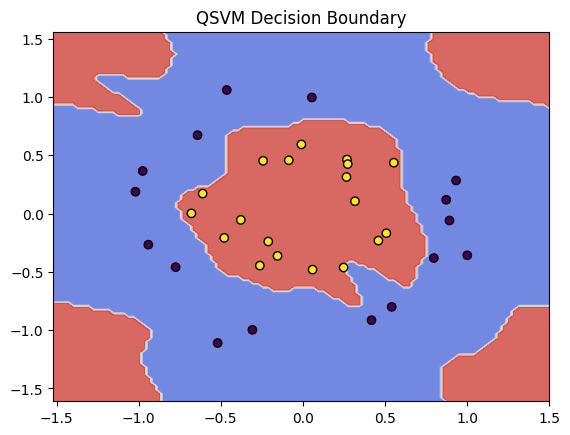

In [ ]:
# Creating an instance of FidelityQuantumKernel
quantum_kernel = FidelityQuantumKernel()

# Evaluating the kernel on the training data to get the kernel matrix
K_train = quantum_kernel.evaluate(x_vec=X_train, y_vec=X_train)

# Training a classical SVM using the quantum kernel
svm = SVC(kernel='precomputed')

# Passing the computed kernel matrix K_train to the fit method
svm.fit(K_train, y_train)

# Evaluating the kernel on the test data against the training data
K_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

# Make predictions on the test set
y_pred = svm.predict(K_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"QSVM Test Accuracy: {accuracy * 100:.2f}%")

# Visualizing the decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Evaluating the kernel for the grid points against the training data
    Z = model.predict(quantum_kernel.evaluate(x_vec=np.c_[xx.ravel(), yy.ravel()], y_vec=X_train))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title('QSVM Decision Boundary')
    plt.show()

# Plotting the decision boundary
plot_decision_boundary(svm, X_train, y_train)